# Image Translation with Conditional GANs



Grace Boatman and Trevor Wexner






# Imports

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os

from google.colab import drive
drive.mount('/content/drive')

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
  
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cuda


In [0]:
# Data directory goes here:
data_dir = '/content/gdrive/My Drive/Pix2Pix_Project/'

# Import and Save Data

In [0]:
# UNCOMMENT to import data
import requests
from os.path import abspath, isdir, join, basename
import tarfile

# base = 'cityscapes'
# URL= 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/' + base + '.tar.gz'
# target_path = data_dir + base + '.tar.gz'
# response = requests.get(URL, stream=True)
# if response.status_code == 200:
#   with open(target_path, 'wb') as f:
#       f.write(response.raw.read())
#       # r = requests.get(dataset_url)
#       # f.write(r.content)
#   obj = tarfile.open(target_path)
#   obj.extractall(data_dir)
#   obj.close()
#   os.remove(target_path)


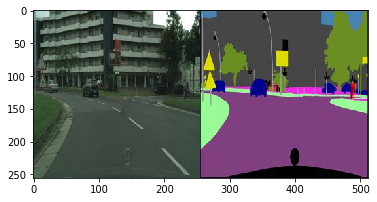

In [0]:
os.listdir(root + 'cityscapes/train')
f = data_dir + 'cityscapes/train/1.jpg'
img=mpimg.imread(f)
plt.imshow(img)

In [0]:
# UNCOMMENT to read in data and SAVE as numpy

# x_train = np.zeros((2975, 256, 256, 3))
# y_train = np.zeros((2975, 256, 256, 3))
# x_test = np.zeros((500, 256, 256, 3))
# y_test = np.zeros((500, 256, 256, 3))
# train_files = os.listdir(data_dir + 'cityscapes/train')
# test_files = os.listdir(data_dir + 'cityscapes/val')
# for i, f in enumerate(train_files):
#   img = mpimg.imread(data_dir + 'cityscapes/train/' + f)
#   x_train[i,:,:,:] = img[:,256:,:]
#   y_train[i,:,:,:] = img[:, :256, :]

# for i, f in enumerate(test_files):
#   img = mpimg.imread(data_dir + 'cityscapes/val/' + f)
#   x_test[i,:,:,:] = img[:,256:,:]
#   y_test[i,:,:,:] = img[:, :256, :]

# np.save(data_dir + 'x_train.npy', x_train)
# np.save(data_dir + 'y_train.npy', y_train)
# np.save(data_dir + 'x_test.npy', x_test)
# np.save(data_dir + 'y_test.npy', y_test)

# Load Data

In [0]:
class Dataset(Dataset):
    def __init__(self, x_data, y_data, transform = None):
        self.x_data = x_data
        self.y_data = y_data
        self.len = len(x_data)   
        self.transform = transform        
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x_data[idx]), self.transform(self.y_data[idx])
        else:
            return self.x_data[idx], self.y_data[idx]

In [0]:
# load in data
x_train = np.load(data_dir + 'x_train.npy')
y_train = np.load(data_dir + 'y_train.npy')
x_test = np.load(data_dir + 'x_test.npy')
y_test = np.load(data_dir + 'y_test.npy')

# reformat data
x_train = x_train/255
y_train = y_train/255
x_test = x_test/255
y_test = y_test/255

# permute and convert to torch tensor
x_train = torch.from_numpy(x_train).type(torch.FloatTensor).permute(0,3,1,2)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor).permute(0,3,1,2)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor).permute(0,3,1,2
y_test = torch.from_numpy(y_test).type(torch.FloatTensor).permute(0,3,1,2)

# function to normalize data
transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Models

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Sequential(nn.Conv2d(3, 64, 4, 2, 1),
                                nn.LeakyReLU())
        self.L2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU())
        self.L3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU())
        self.L4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU())
        self.L5 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU())
        self.L6 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU())
        self.L7 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU())
        self.L8 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU())
        

        self.D1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.Dropout2d(0.5),
                                nn.ReLU())
        self.D2 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.Dropout2d(0.5),
                                nn.ReLU())
        self.D3 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1),
                                nn.BatchNorm2d(512),
                                nn.Dropout2d(0.5),
                                nn.ReLU())
        self.D4 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1),
                                nn.BatchNorm2d(512), 
                                nn.ReLU())
        self.D5 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1),
                                nn.BatchNorm2d(256),
                                nn.ReLU())
        self.D6 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1),
                                nn.BatchNorm2d(128),
                                nn.ReLU())
        self.D7 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU())
        self.D8 = nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1),
                                nn.Tanh())
    def forward(self, x):
        out1 = self.L1(x)
        out2 = self.L2(out1)
        out3 = self.L3(out2)
        out4 = self.L4(out3)
        out5 = self.L5(out4)
        out6 = self.L6(out5)
        out7 = self.L7(out6)
        out8 = self.L8(out7)

        out9 = self.D1(out8)
        out10 = self.D2(torch.cat([out9, out7], dim=1))
        out11 = self.D3(torch.cat([out10, out6], dim=1))
        out12 = self.D4(torch.cat([out11, out5], dim=1))
        out13 = self.D5(torch.cat([out12, out4], dim=1))
        out14 = self.D6(torch.cat([out13, out3], dim=1))
        out15 = self.D7(torch.cat([out14, out2], dim=1))
        out16 = self.D8(torch.cat([out15, out1], dim=1)) 
        return out16



In [0]:
# PatchGAN! with various receptive field sizes
class Discriminator(torch.nn.Module):
    def __init__(self, N = 70):
        """
        N = input for NxN patch size
            Options are 1, 70, 142, and 286
        """
        super().__init__()
        self.N = N               
        if N == 1:
            self.D1 = nn.Sequential(
                        nn.Conv2d(3*2, 64, 1, 1, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 128, 1, 1, 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.Conv2d(128, 1, 1, 1, 1),
                        nn.Sigmoid())
        elif N == 70:
            self.D1 = nn.Sequential(
                        nn.Conv2d(3*2, 64, 4, 2, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 128, 4, 2, 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.Conv2d(128, 256, 4, 2, 1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.Conv2d(256, 512, 4, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 1, 4, 1, 1),
                        nn.Sigmoid())
        elif N == 142:
            self.D1 = nn.Sequential(
                        nn.Conv2d(3*2, 64, 4, 2, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 128, 4, 2, 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.Conv2d(128, 256, 4, 2, 1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.Conv2d(256, 512, 4, 2, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 512, 4, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 1, 4, 1, 1),
                        nn.Sigmoid())
        elif N == 286:
            self.D1 = nn.Sequential(
                        nn.Conv2d(3*2, 64, 4, 2, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 128, 4, 2, 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),
                        nn.Conv2d(128, 256, 4, 2, 1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.Conv2d(256, 512, 4, 2, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 512, 4, 2, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 512, 4, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),
                        nn.Conv2d(512, 1, 4, 1, 1),
                        nn.Sigmoid())

    def forward(self, x):
        x = self.D1(x)
        return x


In [0]:
# Calculate the effective receptive field size!

def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size
 
# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70
142


# Training

In [0]:
# Define train function
def train_cGAN(generator, discriminator, train_loader, optimizerG, optimizerD, numEpochs):
    criterion = nn.BCELoss()
    loss_gen_np = np.zeros(numEpochs)
    loss_dis_np = np.zeros(numEpochs)

    for epoch in range(numEpochs):
        for i, (x_train, y_train) in enumerate(train_loader):
            optimizerD.zero_grad()
            batch_size = len(x_train)
            x_train = x_train.to(device)
            y_train = y_train.to(device)       
            output_gen = generator(x_train)
            output_gen = output_gen.to(device)
            
            output_dis_real = discriminator(torch.cat([x_train, y_train], dim=1))
            output_dis_fake = discriminator(torch.cat([x_train, output_gen], dim=1))
            # discriminator loss
            loss_real = criterion(output_dis_real, torch.ones_like(output_dis_real).to(device))
            loss_fake = criterion(output_dis_fake, torch.zeros_like(output_dis_fake).to(device))
            total_dis_loss = loss_real + loss_fake
            total_dis_loss.backward()
            optimizerD.step() 
            
            optimizerG.zero_grad()
            # generator loss (L1 + cross entropy)
            output_gen = generator(x_train)
            output_gen = output_gen.to(device)
            output_dis_fake = discriminator(torch.cat([x_train, output_gen], dim=1))

            loss = criterion(output_dis_fake, torch.ones_like(output_dis_fake).to(device))
            L1 = 100* torch.mean(torch.abs(y_train - output_gen))
            #smoothL1 = 100 * torch.nn.SmoothL1Loss(output_gen, y_train, reduction='mean')
            #L2 = 100 * torch.mean((y_train - output_gen)**2)
            total_gen_loss = loss + L1
            total_gen_loss.backward()
            optimizerG.step()
         

        loss_gen_np[epoch] = total_gen_loss.item()
        loss_dis_np[epoch] = total_dis_loss.item()
        print('Epoch: ' + str(epoch+1) + ' Loss Gen: ' + str(loss_gen_np[epoch]) + ' Loss Dis: ' + str(loss_dis_np[epoch]))
        with torch.no_grad():
            out = generator(x_train)
        plt.imshow(np.transpose(torchvision.utils.make_grid(x_train[:10], 
                                                            nrow = 5, normalize = True, 
                                                            padding=0).cpu(),(1,2,0)))
        plt.show()
        plt.imshow(np.transpose(torchvision.utils.make_grid(out.to(device)[:10], 
                                                            nrow = 5, normalize = True, 
                                                            padding=0).cpu(),(1,2,0)))
        plt.show()
        plt.imshow(np.transpose(torchvision.utils.make_grid(y_train[:10], 
                                                            nrow = 5, normalize = True, 
                                                            padding=0).cpu(),(1,2,0)))
        plt.show()
    return loss_gen_np, loss_dis_np



In [0]:
# Create train and test sets
train_set = Dataset(x_train, y_train, transform = transform)
test_set = Dataset(x_test, y_test, transform = transform)
# Create data loaders
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 64, shuffle = False)
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator(N = 70).to(device)
# Initialize optimizers
optimizerG = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999))


In [0]:
# TRAIN network
loss_gen, loss_dis = train_cGAN(generator, discriminator, train_loader, optimizerG, optimizerD, numEpochs= 50) 


In [0]:
#SAVE MODEL PARAMETERS and loss

# np.save(data_dir + 'gen_loss.npy', loss_gen)
# np.save(data_dir + 'dis_loss.npy', loss_dis)

# PATH = data_dir + 'generator.pt'
# torch.save(generator.state_dict(), PATH)
# PATH = data_dir + 'discriminator.pt'
# torch.save(discriminator.state_dict(), PATH)

Text(0.5, 1.0, 'cGAN + L1, N = 70, Reversed')

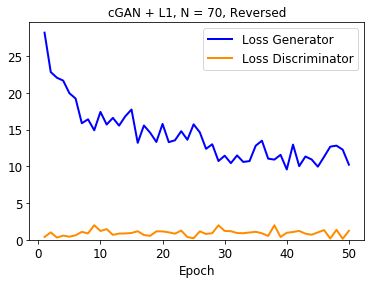

In [0]:
# Loss figure
x = list(np.arange(1, 51))
fig1 = plt.figure()
plt.plot( x, list(loss_gen), marker='', markerfacecolor='blue', 
         markersize=4, color='blue', linewidth=2, label= 'Loss Generator')
plt.plot( x, list(loss_dis), marker='', markerfacecolor='blue', 
         markersize=4, color='darkorange', linewidth=2, label='Loss Discriminator')

ax = plt.gca()
ax.tick_params(axis = 'both', labelsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.ylim(bottom=0)
plt.legend(fontsize = 12)
plt.title('cGAN + L1, N = 70')

# Testing

In [0]:
# LOAD MODEL PARAMETERS
PATH = data_dir + 'generator.pt'
generator = Generator()
generator.load_state_dict(torch.load(PATH))
generator.eval()
generator = generator.to(device)

PATH = data_dir + 'discriminator.pt'
discriminator = Discriminator(N = 70)
discriminator.load_state_dict(torch.load(PATH))
discriminator.eval()
discriminator = discriminator.to(device)

In [0]:
# Calculate pixel-wise test accuracy
def test(generator, test_loader):
    pixel_acc = []
    for i, (inp, gt) in enumerate(test_loader):
        out = generator(inp.to(device))
        acc = torch.mean(torch.abs(out.data.cpu() - gt)/2)
        pixel_acc.append(acc)
    total_acc = 1 - sum(pixel_acc)/len(pixel_acc)
    return total_acc

In [0]:
t = test(generator, test_loader)
t

tensor(0.7750)

In [0]:
# PER PIXEL ACCURACY Results

# N = 1, cGAN + L1: 89.34
# N = 70, cGAN + L1: 88.31
# N = 142, cGAN + L1: 88.57
# N = 286, cGAN + L1: 88.21

# N = 70, cGAN: 84.02
# N = 70, cGAN + L2: 88.52
# N = 70, cGAN + L1, Rev: 77.5

# Visualize

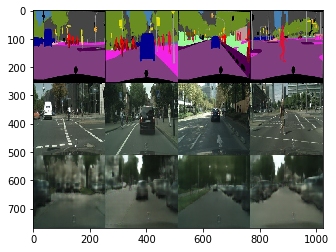

In [0]:
# Visualize Test Results in a Grid (top: input, middle: ground truth, bottom: generated images)
for i, (inp, gt) in enumerate(test_loader):
    if i ==0:
        out = generator(inp.to(device))
grid = torch.cat([inp[0:4].to(device), gt[0:4].to(device), out[0:4]])

plt.imshow(np.transpose(torchvision.utils.make_grid(grid.to(device),
                                                    nrow =4, normalize = True, 
                                                    padding=0).detach().cpu(),(1,2,0)))
plt.show()